In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_SET = os.path.join(os.getcwd(), 'data-set')

In [145]:
train = pd.read_json(os.path.join(DATA_SET, 'train.json'))
test = pd.read_json(os.path.join(DATA_SET, 'test.json'))

## Data Exploration

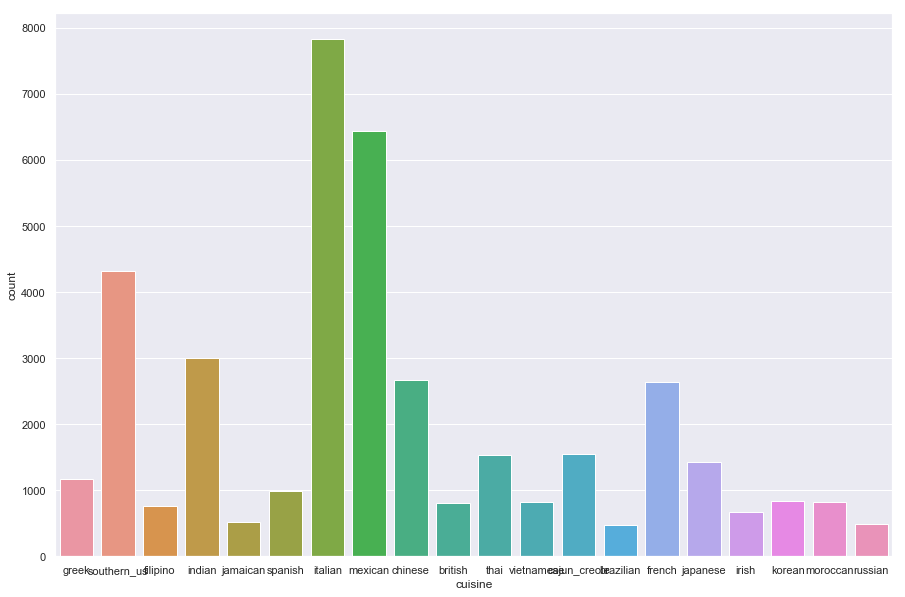

In [4]:
sns.set(rc={'figure.figsize':(15, 10)})
ax = sns.countplot(x='cuisine', data=train)

In [5]:
train['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [6]:
len(train['cuisine'].unique())

20

## Data Preprocessing

#### 1. Count up the frequency of ingredients

In [7]:
from collections import defaultdict

In [8]:
ingredients = defaultdict(int)

In [9]:
for row in train.itertuples():
    for ingredient in getattr(row, 'ingredients'):
        ingredients[ingredient] +=1

In [10]:
most_common_ingredients = sorted(ingredients, key=ingredients.get, reverse=True)

In [11]:
ingredient_count = pd.concat([pd.DataFrame(list(ingredients.keys()), columns=['ingredient']), 
                              pd.DataFrame(list(ingredients.values()), columns=['count'])], 
                             axis=1)

In [12]:
df = ingredient_count.sort_values(by=['count'], ascending=False)

In [13]:
df.iloc[:10]

,ingredient,count
11,salt,18049
54,olive oil,7972
35,onions,7972
29,water,7457
3,garlic,7380
47,sugar,6434
105,garlic cloves,6237
27,butter,4848
13,ground black pepper,4785
115,all-purpose flour,4632


**Show ingredients that contain a specific word**

In [14]:
def find_ingredients(df, word):
    if 'ingredient' not in df.columns:
        print('Error: Need to have an ingredients column!')
        return
    
    if len(word.split()) == 1:
        word = ' {0}|{0} '.format(word) 
    
    return df[df['ingredient'].str.contains(word, na=False)]

#### 2. Replacing similar ingredients

In [19]:
import re

In [20]:
# descriptors = dict.fromkeys(['fresh ', ' fresh', 'diced ', ' diced', 'minced ', ' minced', 
#                              'chopped ', ' chopped'], '')

descriptors = dict.fromkeys(['chopped ', ' chopped', 'minced ', ' minced', 'diced ', ' diced', 'fresh ', ' fresh', 
                             'toasted ', ' toasted', 'large ', ' large', 'small ', ' small', 'medium ', ' medium', 
                             'crushed ', ' crushed', 'canned ', ' canned', 'low sodium ', ' low sodium', 
                             'roasted ', ' roasted', 'salted ', ' salted', 'unsalted ', ' unsalted', 
                             'granulated ', ' granulated', 'dried ', ' dried', 'unsweetened ', ' unsweetened', 
                             'sweetened ', ' sweetened', 'lean ', ' lean', 'ground ', ' ground'], 
                            '')

descriptors_pattern = re.compile('|'.join(descriptors.keys()))

In [204]:
# oil = {'extra-virgin olive oil': 'olive oil', 'vegetable oil': 'oil'}
olive_oil = dict.fromkeys(['extra-virgin olive oil', 'olive oil flavored cooking spray', 'olive oil cooking spray',
                           'mild olive oil', 'olive oil spray', 'pure olive oil', 'extra light olive oil', 
                           'virgin olive oil', 'garlic olive oil', 'lemon olive oil', 'basil olive oil'], 
                          'olive oil')

olive_oil['vegetable oil'] = 'oil'
olive_oil_pattern = re.compile('|'.join(olive_oil.keys()))

In [205]:
def replace_similar_ingredients(ingredient):
    """This function will replace, remove, or modify the ingredients so we have a better representation of the ingredients."""

    # Removes descriptive words such as 'chopped', 'minced', 'large', 'fresh', etc.
    ingredient = descriptors_pattern.sub(lambda m: descriptors[m.group(0)], ingredient)
    
    # Aggregates all olive oil variants into olive oil
    ingredient = olive_oil_pattern.sub(lambda m: olive_oil[m.group(0)], ingredient)
    
    # Specific ingredient replacements
    ingredient = ingredient.replace('hardboiled egg', 'egg') # Use hardboiled because we only retain letters
    ingredient = ingredient.replace('garlic cloves', 'garlic')
    
    return ingredient

In [146]:
# def replace_similar_ingredients(i):
#     #Removes or replaces extra words of the ingredients to have an uniform representation of the ingredients  
    
#     i = i.replace('fresh ', '').replace(' fresh','').replace('diced ','')
#     i = i.replace('minced ','').replace('chopped ','')
#     i = i.replace('garlic cloves','garlic').replace('ground black pepper','black pepper').replace('large eggs','eggs')
#     i = i.replace('extravirgin olive oil','olive oil').replace('fresh ginger','ginger').replace('allpurpose flour','flour')
#     i = i.replace('vegetable oil', 'oil')
   
#     return i

In [148]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bluebehree/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [206]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [208]:
def clean_ingredient_list(ingredients):
    # Removes all non-punctuation
    letters_pattern = re.compile('[^a-zA-Z ]')
    ingredients = [letters_pattern.sub('', ingredient) for ingredient in ingredients]
    
    ingredients = [ingredient.lower() for ingredient in ingredients]
    ingredients = [replace_similar_ingredients(ingredient) for ingredient in ingredients]
    ingredients = [wordnet_lemmatizer.lemmatize(ingredient) for ingredient in ingredients]
    
    return ingredients

In [209]:
def clean_data(train, test):
    train['set'] = 'train'
    test['set'] = 'test'
    
    data = pd.concat([train, test], sort=True, ignore_index=True)
    
    train.drop(columns='set', inplace=True)
    test.drop(columns='set', inplace=True)
    
    data['ingredients_clean'] = data['ingredients'].apply(clean_ingredient_list)
    data['ingredients_string'] = data['ingredients_clean'].apply(lambda ingredients: ' '.join(ingredients))
    
    data.drop(columns=['ingredients', 'ingredients_clean'], inplace=True)
    
    train = data.loc[data['set']=='train'].drop(columns='set')
    test = data.loc[data['set']=='test'].drop(columns=['set', 'cuisine'])

    train.to_csv(os.path.join(DATA_SET, 'train_processed.csv'), index=False)
    test.to_csv(os.path.join(DATA_SET, 'test_processed.csv'), index=False)

In [210]:
clean_data(train, test)

#### 3. Convert cuisine classes using LabelEncoder

In [211]:
from sklearn.preprocessing import LabelEncoder

In [212]:
data = pd.read_csv('data-set/train_processed.csv')

In [213]:
number_of_cuisines = len(data['cuisine'].unique())
print('There are {} unique cuisines.'.format(number_of_cuisines))

There are 20 unique cuisines.


In [214]:
lb = LabelEncoder()

In [215]:
target = lb.fit_transform(data['cuisine'])

In [216]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [218]:
cuisine_list = [lb.inverse_transform([i])[0] for i in range(20)]

#### 4. Convert words to a vector using tf-idf vectorizer

In [219]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [220]:
corpus = data['ingredients_string']

In [221]:
tfidf = TfidfVectorizer(stop_words='english', binary=False, max_df=.6, analyzer='word', 
                        ngram_range=(1,1), sublinear_tf=False, token_pattern=r'\w+', norm='l2')

In [222]:
matrix = tfidf.fit_transform(data['ingredients_string'])

#### 5. Split train and test set

In [223]:
from sklearn.model_selection import train_test_split

In [224]:
X_train, X_test, y_train, y_test = train_test_split(matrix, target, test_size=0.3, random_state=101)

## Train and test model

In [225]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [226]:
clf_svc = LinearSVC(random_state=101)
clf_nb = MultinomialNB()
clf_dt = DecisionTreeClassifier(random_state=101)
clf_rfc = RandomForestClassifier()
clf_xgb = xgb.XGBClassifier()

In [227]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [228]:
from timeit import default_timer as timer

In [242]:
def train_and_test(clf, X_train, X_test, y_train, y_test):
    start = timer()
    clf.fit(X_train, y_train)
    end = timer()
    print('Training time: {0:.2f}s\n'.format(end-start))
    
    print('Training score: {}'.format(clf.score(X_train, y_train)))
    print('Testing score: {}\n'.format(clf.score(X_test, y_test)))
    
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=cuisine_list))
    
    return clf

In [243]:
print('Training and testing a Linear SVM Classifier...')
clf_svc = train_and_test(clf_svc, X_train, X_test, y_train, y_test)

Training and testing a Linear SVM Classifier...
Training time: 1.84s

Training score: 0.8643008512625265
Testing score: 0.7904969412553423

              precision    recall  f1-score   support

   brazilian       0.81      0.59      0.68       135
     british       0.65      0.45      0.53       246
cajun_creole       0.73      0.70      0.72       474
     chinese       0.79      0.86      0.83       792
    filipino       0.74      0.57      0.65       230
      french       0.62      0.62      0.62       784
       greek       0.80      0.74      0.76       329
      indian       0.88      0.90      0.89       910
       irish       0.69      0.56      0.61       198
     italian       0.81      0.89      0.85      2316
    jamaican       0.83      0.76      0.79       143
    japanese       0.85      0.70      0.77       431
      korean       0.85      0.78      0.81       258
     mexican       0.89      0.92      0.91      1911
    moroccan       0.80      0.78      0.79      

In [244]:
print('Training and testing a Naive Bayes Classifier...')
clf_nb = train_and_test(clf_nb, X_train, X_test, y_train, y_test)

Training and testing a Naive Bayes Classifier...
Training time: 0.03s

Training score: 0.6815487949427104
Testing score: 0.6619458644096203

              precision    recall  f1-score   support

   brazilian       0.95      0.16      0.27       135
     british       1.00      0.05      0.10       246
cajun_creole       0.77      0.48      0.59       474
     chinese       0.58      0.91      0.71       792
    filipino       0.96      0.10      0.17       230
      french       0.52      0.39      0.44       784
       greek       0.89      0.28      0.43       329
      indian       0.76      0.90      0.82       910
       irish       1.00      0.06      0.11       198
     italian       0.63      0.90      0.75      2316
    jamaican       1.00      0.12      0.21       143
    japanese       0.93      0.53      0.67       431
      korean       0.99      0.33      0.49       258
     mexican       0.79      0.91      0.84      1911
    moroccan       0.96      0.27      0.42     

In [245]:
print('Training and testing a Decision Tree Classifier...')
clf_dt = train_and_test(clf_dt, X_train, X_test, y_train, y_test)

Training and testing a Decision Tree Classifier...
Training time: 8.41s

Training score: 0.9996408174993714
Testing score: 0.6048772312075756

              precision    recall  f1-score   support

   brazilian       0.38      0.41      0.39       135
     british       0.26      0.27      0.26       246
cajun_creole       0.52      0.54      0.53       474
     chinese       0.65      0.65      0.65       792
    filipino       0.42      0.37      0.39       230
      french       0.36      0.37      0.37       784
       greek       0.55      0.54      0.54       329
      indian       0.75      0.74      0.74       910
       irish       0.34      0.30      0.32       198
     italian       0.69      0.74      0.72      2316
    jamaican       0.61      0.51      0.56       143
    japanese       0.57      0.54      0.55       431
      korean       0.55      0.47      0.51       258
     mexican       0.79      0.81      0.80      1911
    moroccan       0.50      0.47      0.48   

In [246]:
print('Training and testing a Random Forest Classifier')
clf_rfc = train_and_test(clf_rfc, X_train, X_test, y_train, y_test)

Training and testing a Random Forest Classifier


/Users/bluebehree/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training time: 4.84s

Training score: 0.9943608347401315
Testing score: 0.6838179837425626

              precision    recall  f1-score   support

   brazilian       0.72      0.47      0.57       135
     british       0.39      0.28      0.32       246
cajun_creole       0.61      0.65      0.63       474
     chinese       0.64      0.83      0.72       792
    filipino       0.59      0.40      0.47       230
      french       0.42      0.44      0.43       784
       greek       0.68      0.55      0.61       329
      indian       0.77      0.87      0.81       910
       irish       0.66      0.33      0.44       198
     italian       0.68      0.86      0.76      2316
    jamaican       0.79      0.45      0.57       143
    japanese       0.70      0.55      0.61       431
      korean       0.75      0.48      0.59       258
     mexican       0.84      0.89      0.86      1911
    moroccan       0.78      0.47      0.59       247
     russian       0.62      0.17      0.27

In [247]:
print('Training and testing a XGBoost Classifier...')
clf_xgb = train_and_test(clf_xgb, X_train, X_test, y_train, y_test)

Training and testing a XGBoost Classifier...
Training time: 143.23s

Training score: 0.7745770626055098
Testing score: 0.7271432162909578

              precision    recall  f1-score   support

   brazilian       0.81      0.45      0.58       135
     british       0.77      0.22      0.35       246
cajun_creole       0.76      0.67      0.71       474
     chinese       0.75      0.83      0.79       792
    filipino       0.71      0.44      0.55       230
      french       0.53      0.49      0.51       784
       greek       0.82      0.67      0.74       329
      indian       0.87      0.85      0.86       910
       irish       0.77      0.43      0.55       198
     italian       0.66      0.89      0.76      2316
    jamaican       0.90      0.64      0.75       143
    japanese       0.88      0.58      0.70       431
      korean       0.86      0.67      0.75       258
     mexican       0.86      0.89      0.87      1911
    moroccan       0.86      0.68      0.76       

## Optimizing Linear SVC

In [255]:
def optimize_model(clf, X_train, y_train):
    parameters = {'C':(1, 0.1, 0.01, 0.05, 0.5, 0.001), 'max_iter':(500, 1000, 2000, 5000, 10000)}

    gs = GridSearchCV(estimator=clf, param_grid=parameters, cv=5)
    gs.fit(X_train, y_train)
    
    return gs.best_estimator_

In [256]:
clf = LinearSVC(random_state=101)
clf = optimize_model(clf, X_train, y_train)

In [257]:
print('Training and testing on best Linear SVM classifier...')
clf = train_and_test(clf, X_train, X_test, y_train, y_test)

Training and testing on best Linear SVM classifier...
Training time: 1.45s

Training score: 0.851118853489458
Testing score: 0.7912511522668231

              precision    recall  f1-score   support

   brazilian       0.82      0.59      0.69       135
     british       0.69      0.44      0.54       246
cajun_creole       0.74      0.69      0.71       474
     chinese       0.79      0.87      0.83       792
    filipino       0.75      0.59      0.66       230
      french       0.62      0.62      0.62       784
       greek       0.80      0.72      0.76       329
      indian       0.87      0.91      0.89       910
       irish       0.70      0.56      0.62       198
     italian       0.80      0.90      0.85      2316
    jamaican       0.84      0.76      0.79       143
    japanese       0.85      0.69      0.76       431
      korean       0.86      0.76      0.80       258
     mexican       0.89      0.93      0.91      1911
    moroccan       0.82      0.79      0.80 